In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%load_ext autoreload
%autoreload 1
%aimport wdwrap
#import wdwrap as wd

In [4]:
color={
    'U': '#a472ce',
    'B': '#72a0ce',
    'V': '#83d073',
    'rv1': '#0f12bf',
    'rv2': '#dc1127',
}

## Load data

In [5]:
P = 20.1782302  # RaVeSpAn fit
T0 = 5096.50028

In [6]:
U = pd.read_table('guide-data/LL-Aqr.Ibanoglu.U.dat',delim_whitespace=True, names=['hjd', 'mag'])
B = pd.read_table('guide-data/LL-Aqr.Ibanoglu.B.dat',delim_whitespace=True, names=['hjd', 'mag'])
V = pd.read_table('guide-data/LL-Aqr.Ibanoglu.V.dat',delim_whitespace=True, names=['hjd', 'mag'])

In [7]:
RV = pd.read_table('guide-data/LL-Aqr.rv.dat',delim_whitespace=True, comment='#',
                   names=['hjd', 'rv1', 'rv1_e', 'rv2', 'rv2_e', 'instr'])

In [8]:
U

,hjd,mag
0,53941.4868,9.837
1,53941.4871,9.847
2,53941.4875,9.854
3,53941.4878,9.837
4,53941.4935,9.855
...,...,...
1920,54392.4658,9.883
1921,54392.4664,9.890
1922,54392.4668,9.842
1923,54392.4671,9.838


### Time and Phase

In [9]:
for m in [U, B, V, RV]:
    m.index = pd.DatetimeIndex (pd.to_datetime(2400000.5+m['hjd'], origin='julian', unit='D'))
    m['ph'] = (m['hjd'] - T0) % (P) / (P)

## Plot data

In [10]:
#sns.lineplot(x=U['ph'],y=U['mag'])

In [11]:
def plot_curves(U=None,B=None,V=None,RV=None, mark='.', time='ph', share_time=True):
    fig, (ax_ubv,ax_rv) = plt.subplots(nrows=2, ncols = 1, sharex=share_time)
    fig.set_size_inches(20,10)
    for m, c in zip([U, B, V], 'UBV'):
        if m is not None:
            ax_ubv.plot(m[time], m['mag'], mark, color=color[c], alpha=1, ms=10, label=c)
    ax_ubv.legend(loc='best')
    ax_ubv.invert_yaxis()
    if RV is not None:
        for c in ['rv1', 'rv2']:
            ax_rv.plot(RV[time], RV[c], mark, color=color[c], alpha=1, ms=10, label=c)
    ax_rv.legend(loc='best')
    ax_rv.set_xlabel(time)

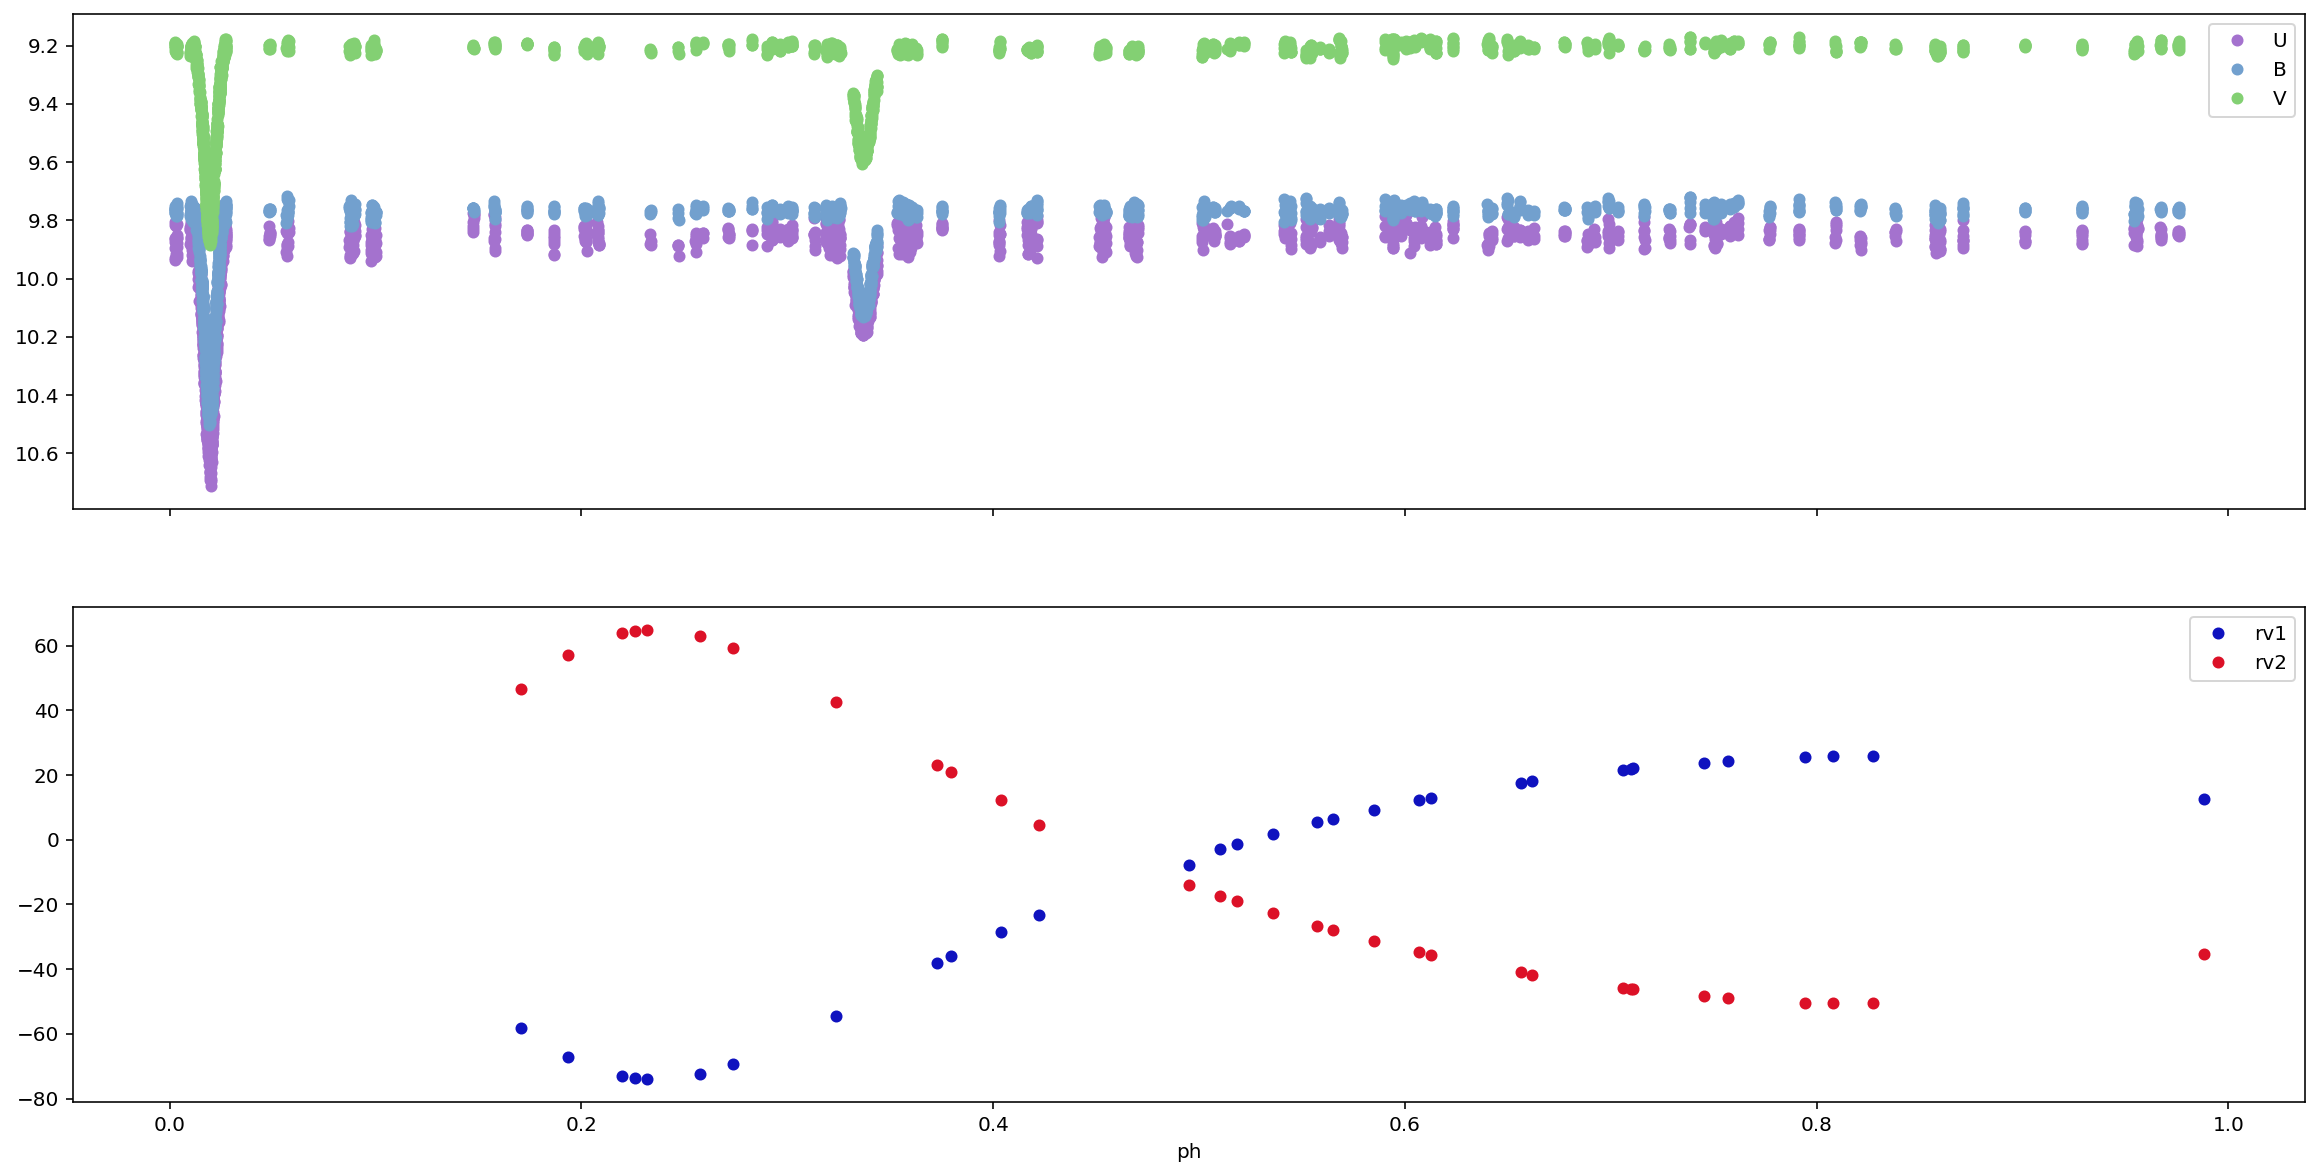

In [12]:
plot_curves(U,B,V,RV)

## Binning

In [13]:
def phase_bin(data, bins, cols=['mag']):
    phase = np.linspace(0,1,bins+1)
    cut = pd.cut(data['ph'], phase, precision=5)
    ret = pd.DataFrame(phase[:-1], columns=['ph'])
    for c in cols:
        ret[c] = list(data[c].groupby(cut).mean())
    return ret

In [14]:
def phase_bin2(data: pd.DataFrame, tau, mean_cols=['mag'], sig_cols=['mag_e']):
    s = data.sort_values('ph')
    n = len(data)
    
    phase = np.linspace(0,1,bins+1)
    cut = pd.cut(data['ph'], phase, precision=5)
    ret = pd.DataFrame(phase[:-1], columns=['ph'])
    for c in cols:
        ret[c] = list(data[c].groupby(cut).mean())
    return ret

In [15]:
light_bins = 1000
rv_bins = 1000

In [16]:
Ub = phase_bin(U, light_bins)
Bb = phase_bin(B, light_bins)
Vb = phase_bin(V, light_bins)
RVb = phase_bin(RV, rv_bins, cols=['rv1', 'rv2'])

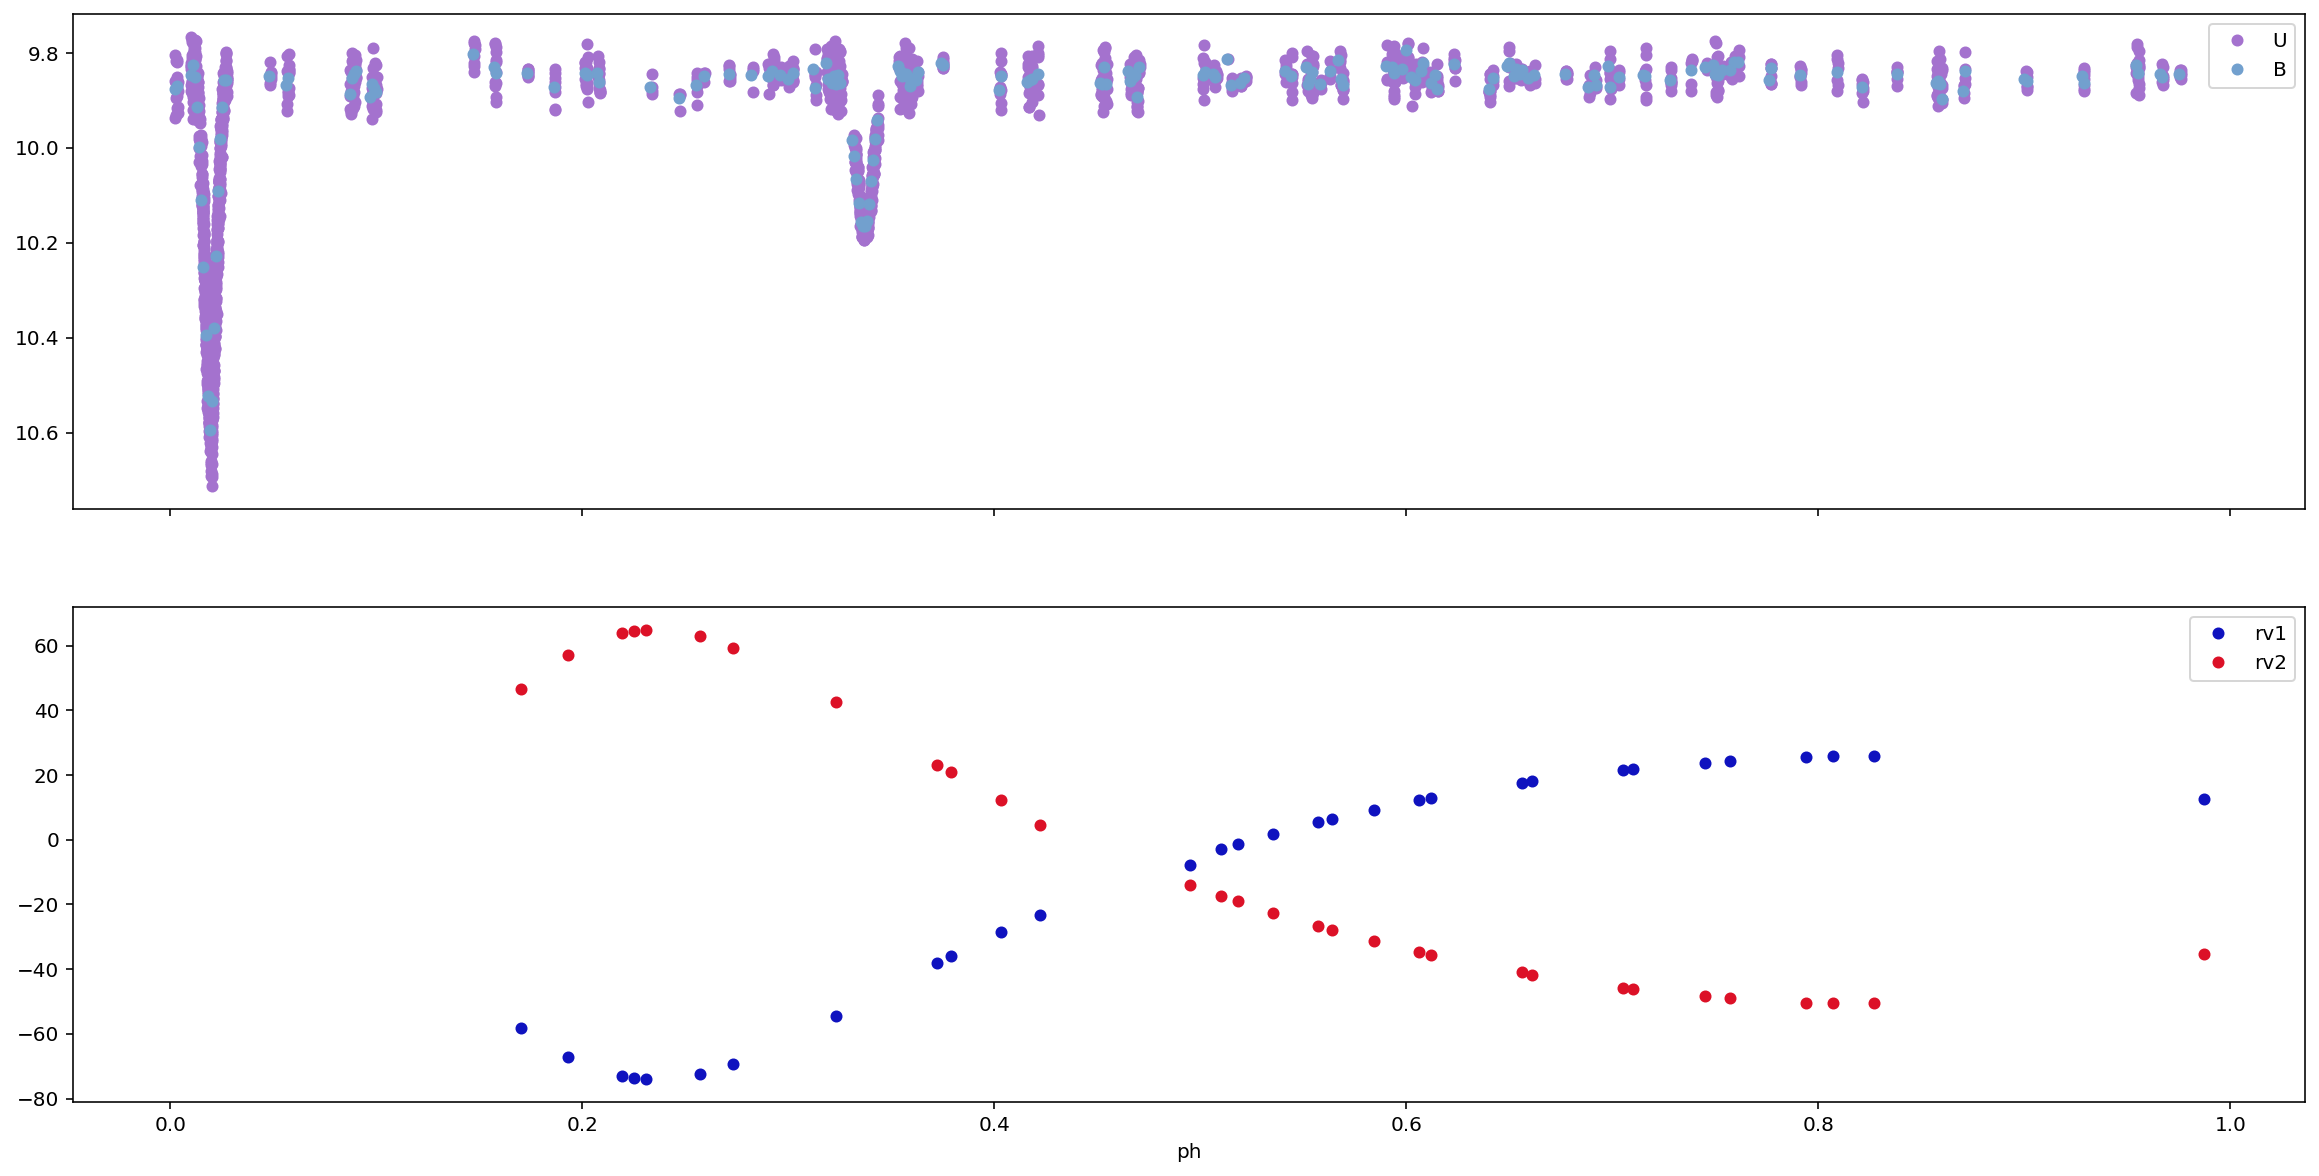

In [353]:
plot_curves(U,Ub,RV=RVb)

## Modeling

In [254]:
model = wdwrap.default_binary()

In [255]:
print(model)

MPAGE=1(light curves) NREF=1 MREF=1(approximate) IFSMV1=1(move in longitude) IFSMV2=1(move in longitude) ICOR1=1(apply) ICOR2=1(apply) IF3B=0(ignore third body parameters) LD1=2(fixed log law) LD2=2(fixed log law)
JDPHS=2(phase) HJD0=2452108.31611 PERIOD=269.214 DPDT=-0.0 PSHIFT=0.0 STDEV=0.0 NOISE=1(scales with sqrt(level)) SEED=138472375.0
HJDST=44659.0 HJDSP=44659.1 HJDIN=0.0 PHSTRT=-0.1 PHSTOP=1.1 PHIN=0.001 PHN=0.25
MODE=2(detached binaries, no constraints on the potentials) IPB=0(L2 computed from T1 T2 L1) IFAT1=1(atmosphere) IFAT2=1(atmosphere) N1=50 N2=50 PERR0=4.836918 DPERDT=0.0 THE=0.0 VUNIT=100.0
E=0.0 A=256.6006 F1=1.0 F2=1.0 VGA=-0.3474 XINCL=88.017 GR1=0.32 GR2=0.32 ABUNIN=-0.0
TAVH=0.5 TAVC=0.4609 ALB1=0.5 ALB2=0.5 POTH=7.94501 POTC=6.54438 RM=1.0 XBOL1=0.633 XBOL2=0.231 YBOL1=0.475 YBOL2=0.302
A3B=95.0905 P3B=33.212607 XINC3B=76.0 E3B=0.13431 PERR3B=1.5707963 TCONJ3B=44662.967507
IBAND=7(V) HLUM=6.422 CLUM=4.8 XH=0.513 XC=0.644 YH=0.274 YC=0.526 EL3=0.0 OPSF=0.0 ZERO=1

In [302]:
model['PERIOD'] = P
model['HJD0'] = T0
model['IBAND'] = 7
model['PHIN'] = 0.5/light_bins
model['PHSTRT'] = -0.5
model['PHSTOP'] = 1.5
model['ZERO'] = 9.2
model['VUNIT'] = 1
model['XINCL'] = 80
model['E'] = 0.3
model['PERR0'] = 1
model['A'] = 40

In [303]:
model['A'].__doc__

'(a): The length of the semi-major axis in solar radii (6.95660*10^5 km [Haberreiter+2008])\n    of the relative orbital ellipse.\n    It is the sum of the two absolute semi-major axes, so a = a1 + a2'

In [304]:
model.reset()
RVc = model.veloc_df
Vc = model.light_df

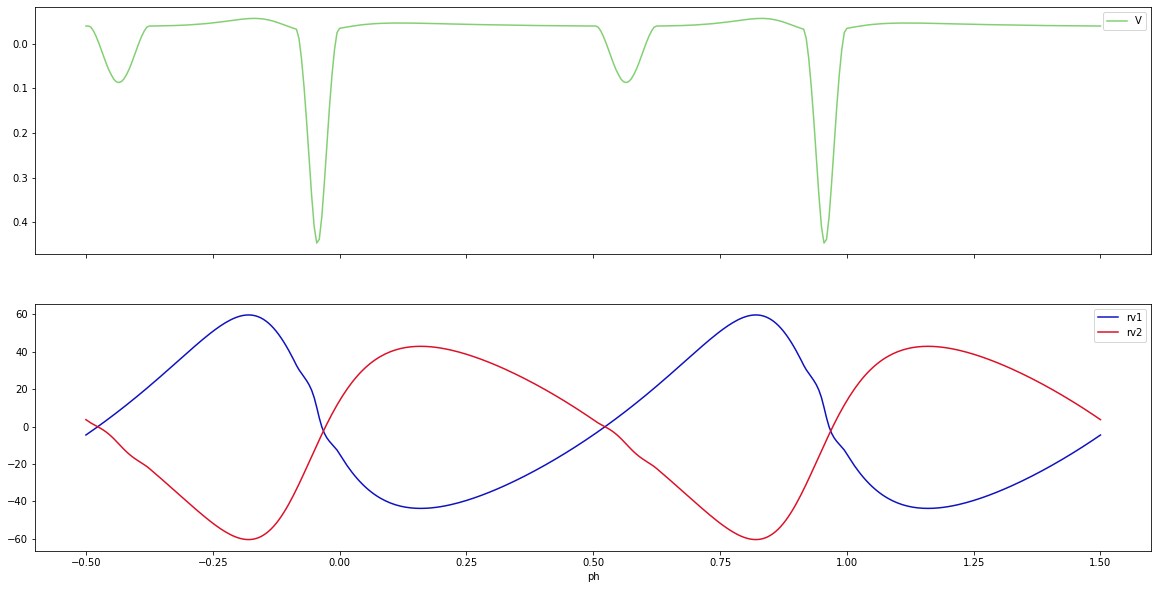

In [305]:
plot_curves(V=Vc, RV=RVc, mark='-')

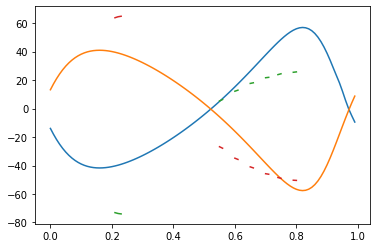

In [259]:
plt.plot(RVc.ph, RVc.rv1)
plt.plot(RVc.ph, RVc.rv2)
plt.plot(RVb.ph, RVb.rv1)
plt.plot(RVb.ph, RVb.rv2)

In [260]:
pd.DataFrame(model.light_cal)

AttributeError: 'Bundle' object has no attribute 'light_cal'

In [ ]:
with pm.Model() as mcmc:

In [ ]:
model.light_cal

$ dX_t = \lambda `X_t + :\sigma`^2 dW_t $

In [261]:
x = np.arange(-400,400,10)*100 #*1e3

# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

In [218]:
# Gaussian function
gaussl = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gaussl(x=x,amp=amp_true, size=size_true, ps=ps_true )

In [219]:
# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
f = f_true + noise 
f_error = np.ones_like(f_true)*0.05*f.max()

In [220]:
# define the model/function to be fitted.
def model_mc(x, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)

    @pm.deterministic(plot=False)
    def gauss(amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

In [221]:
MDL = pm.MCMC(modelx(x,f))

AttributeError: module 'pymc3' has no attribute 'MCMC'

In [266]:
class MyGauss(tt.Op):
    itypes = [tt.dscalar,tt.dscalar,tt.dscalar] # expects a vector of parameter values when called
    otypes = [tt.dvector] # outputs a single scalar value (the log likelihood)

    def __init__(self, x):
        self.x = x
    def perform(self, node, inputs, outputs):
#        print (inputs)
        (amp, size, ps) = inputs
#        print (amp, size, ps)
        model.reset()
        model.light_df
        e = -1*(np.pi**2*float(size)*self.x/(3600.*180.))**2/(4.*np.log(2.))
        outputs[0][0] = amp*np.exp(e)+ps
#        print (outputs)

In [266]:
class WdOp(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dvector] # outputs a vector value 

    def __init__(self, x, wdmodel):
        self.x = x
        self.wdmodel = wdmodel
    def perform(self, node, inputs, outputs):
#        print (inputs)
        (amp, size, ps) = inputs
#        print (amp, size, ps)
        model.reset()
        model.light_df
        e = -1*(np.pi**2*float(size)*self.x/(3600.*180.))**2/(4.*np.log(2.))
        outputs[0][0] = amp*np.exp(e)+ps
#        print (outputs)

In [269]:
myGauss = MyGauss(x)
with pm.Model() as model_mc3:
    amp = pm.Uniform('amp', -100,100)#, 0.05, 0.4)
    size = pm.Uniform('size', -100,100)#, -10, 20)
    ps = pm.Uniform('ps', -100,100)
    mu = pm.Deterministic('zupa', myGauss(amp,size,ps))
    y = pm.Normal('y', mu=myGauss(amp,size,ps), tau=1.0/f_error**2, observed=f)
#    y = pm.Normal('y', mu=size*2, sigma=0.1, observed=np.random.randn(100)+1)
#    zz = pm.Normal('zz', mu=size, sigma=0.01,observed=1)
#    connnst = pm.Constant('Konstanty',44.4)
#     start = [0.15,1.0,0.15]
#     pm.DensityDist('likelihood', my_loglike,
#                    observed={'theta': (m, c), 'x': x, 'data': data, 'sigma': sigma})

#     @pm.deterministic(plot=False)
#     g = pm.DensityDist('gaussik', lambda amp, size, ps: myGauss(amp, size, ps), 
#                         observed={'amp':amp, 'size':size, 'ps':ps}, value=f)
#     y = pm.Normal('y', mu=g, tau=1.0/f_error**2, value=f, observed=True)
#     def gauss(x=x, amp=amp, size=size, ps=ps):
#         e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
#         return amp*np.exp(e)+ps
    
#     y = pm.Normal('y', mu=gauss(x), tau=1.0/f_error**2,observed=f)
# #    pm.Lognormal('likelihood', mu)
#    y = pm.DensityDist('beta', gauss, testval={'amp':amp, 'size':size, 'ps':ps}, )
    MDL = pm.sample(100, tune=100, cores=8)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Slice: [ps]
>Slice: [size]
>Slice: [amp]
Sampling 8 chains, 0 divergences: 100%|██████████| 1600/1600 [7:21:02<00:00, 16.54s/draws]  
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


ValueError: x and y must have same first dimension, but have shapes (80,) and (24000,)

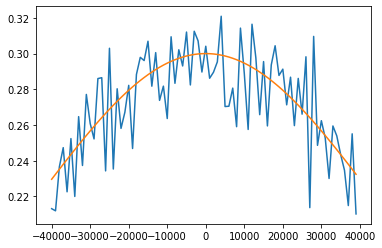

In [263]:
plt.plot(x,y.tag.test_value)
plt.plot(x,f_true)
plt.plot(x,MDL.size)

In [ ]:
plt.plot(amp.tag.test_value)
#plt.plot(x,f_true)